In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import pandas as pd
import dask.dataframe as dd
from dask.distributed import Client

# What data will we use?

In [3]:
# Files that we will use for this example.
for file in os.listdir('./data/'):
    print('./data/' + file + '   -   size: %1.2f'
          %(os.path.getsize('./data/'+file)/1024/1024/1024)+'GB')

./data/yellow_tripdata_2015-05.csv   -   size: 1.92GB
./data/yellow_tripdata_2015-11.csv   -   size: 1.65GB
./data/yellow_tripdata_2015-10.csv   -   size: 1.80GB
./data/yellow_tripdata_2015-04.csv   -   size: 1.91GB
./data/yellow_tripdata_2015-12.csv   -   size: 1.67GB
./data/yellow_tripdata_2015-06.csv   -   size: 1.80GB
./data/yellow_tripdata_2015-07.csv   -   size: 1.69GB
./data/yellow_tripdata_2015-03.csv   -   size: 1.94GB
./data/yellow_tripdata_2015-02.csv   -   size: 1.81GB
./data/yellow_tripdata_2015-01.csv   -   size: 1.85GB
./data/yellow_tripdata_2015-09.csv   -   size: 1.64GB
./data/yellow_tripdata_2015-08.csv   -   size: 1.63GB


# Using pandas

In [4]:
%%time
# Parse date time columns as datetime64[ns]
date_cols = ['tpep_pickup_datetime', 'tpep_dropoff_datetime'] 
df = []
for i in range(1,13):
    df.append(pd.read_csv('data/yellow_tripdata_2015-' + '%02d'%i + '.csv',
                          date_parser = pd.to_datetime,  
                          parse_dates = date_cols))
df = pd.concat(df, sort=False)

CPU times: user 13min 24s, sys: 3min 35s, total: 17min
Wall time: 15min 3s


In [5]:
def calculate_distance(df):
    """Function to transform lat-lon coordinates to distance 
    according to (https://www.movable-type.co.uk/scripts/latlong.html)"""
    
    lon1 = np.radians(df.pickup_longitude)
    lon2 = np.radians(df.dropoff_longitude)
    lat1 = np.radians(df.pickup_latitude)
    lat2 = np.radians(df.dropoff_latitude)
    dlon = lon2 - lon1
    dlat = lat2 - lat1 
    a =  np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    R = 6373
    return R * c

CPU times: user 2min 1s, sys: 4min 11s, total: 6min 12s
Wall time: 4min 4s


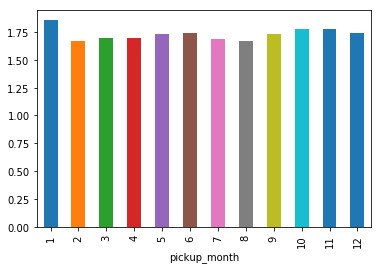

In [6]:
%%time
df['distance'] = calculate_distance(df)
df['fare_per_mile'] = df.fare_amount/df.distance
df['trip_distance_km'] = df.trip_distance*1.609344
df['time_in_cab'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df['pickup_hour'] = df.tpep_pickup_datetime.dt.hour
df['pickup_dow'] = df.tpep_pickup_datetime.dt.dayofweek
df['pickup_month'] = df.tpep_pickup_datetime.dt.month

df.groupby(df.pickup_month).tip_amount.mean().sort_index().plot.bar()

# Using Dask

In [8]:
client = Czlient(processes=False)
client

Client Scheduler: inproc://192.168.3.176/24483/1 Dashboard: http://localhost:8787/status,Cluster Workers: 1 Cores: 12 Memory: 17.18 GB


CPU times: user 29min 54s, sys: 54min 14s, total: 1h 24min 9s
Wall time: 10min 14s


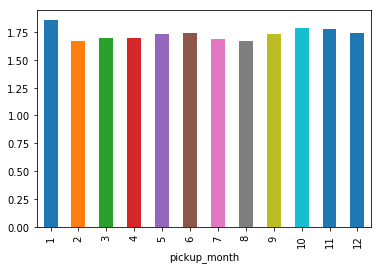

In [9]:
%%time 
ddf = dd.read_csv('data/yellow_tripdata_2015-*.csv',blocksize=13e7,assume_missing=True)
ddf['distance'] = ddf.map_partitions(lambda df: calculate_distance(df))
ddf['fare_per_mile'] = ddf.fare_amount/ddf.distance
ddf['trip_distance_km'] = ddf.trip_distance*1.609344
ddf['tpep_pickup_datetime'] = dd.to_datetime(ddf.tpep_pickup_datetime, errors='ignore')
ddf['tpep_dropoff_datetime'] = dd.to_datetime(ddf.tpep_dropoff_datetime, errors='ignore')
ddf['time_in_cab'] = ddf.tpep_dropoff_datetime - ddf.tpep_pickup_datetime
ddf['pickup_hour'] = ddf.tpep_pickup_datetime.dt.hour
ddf['pickup_dow'] = ddf.tpep_pickup_datetime.dt.dayofweek
ddf['pickup_month'] = ddf.tpep_pickup_datetime.dt.month

ddf = client.persist(ddf)
ddf.groupby(ddf.pickup_month).tip_amount.mean().compute().sort_index().plot.bar()